## Data Preprocessing

#### Combining the Dataset 

In [43]:
import os
import pandas as pd

# Use current directory as base
base_dir = os.getcwd()

# List of label CSVs
csv_files = [
    "Matrices_Test_2014_labels.csv",
    "Matrices_Train_2014_labels.csv",
    "train_InkML_2013_labels.csv",
    "trainData_2012_part1_labels.csv",
    "trainData_2012_part2_labels.csv",
]

# Combine all into one DataFrame
df_list = []
for csv_name in csv_files:
    df = pd.read_csv(csv_name)
    
    # Prepend full base path to image_path
    df["image_path"] = df["image_path"].apply(
        lambda x: os.path.join(base_dir, x)
    )
    
    # Optional: Keep only if image exists
    df = df[df["image_path"].apply(os.path.exists)]

    # Rename latex column to label
    df = df.rename(columns={"latex": "label"})
    df_list.append(df)

# Combine all CSVs into one big DataFrame
full_df = pd.concat(df_list, ignore_index=True)

print(f"✅ Total samples with images: {len(full_df)}")
print(full_df.head())

✅ Total samples with images: 10550
                                          image_path  \
0  /Users/vyjayanthi/Desktop/Python codes/Math Eq...   
1  /Users/vyjayanthi/Desktop/Python codes/Math Eq...   
2  /Users/vyjayanthi/Desktop/Python codes/Math Eq...   
3  /Users/vyjayanthi/Desktop/Python codes/Math Eq...   
4  /Users/vyjayanthi/Desktop/Python codes/Math Eq...   

                                               label  
0  $ A ^ {5} = \begin {pmatrix} 3 & 2 \\ 1 & 1 \e...  
1  $ \begin {pmatrix} 1 & 1 & 3 \\ 0 & 1 & 4 \end...  
2  $ \begin {pmatrix} a & 0 \\ b & 0 \end {pmatri...  
3  $ M = \begin {pmatrix} 1 & 2 & 3 \\ 0 & 4 & 5 ...  
4  $ A = \begin {pmatrix} 1 & 2 \\ 0 & - 2 \end {...  


#### Tokenize LaTeX Labels

In [45]:
import re

def latex_tokenizer(expr):
    pattern = r'(\\[a-zA-Z]+|[{}_^]|[0-9]+|[a-zA-Z]|[\+\-\*/=<>.,()])'
    return re.findall(pattern, expr)


#### Build Vocabulary

In [47]:
from collections import Counter

# Special tokens
special_tokens = ["[PAD]", "[SOS]", "[EOS]", "[UNK]"]
token_counter = Counter()

# Tokenize and count
for label in full_df["label"]:
    tokens = latex_tokenizer(label)
    token_counter.update(tokens)

# Build vocab
all_tokens = special_tokens + sorted(token_counter)
token_to_id = {token: idx for idx, token in enumerate(all_tokens)}
id_to_token = {idx: token for token, idx in token_to_id.items()}

print(f"✅ Vocab size: {len(token_to_id)}")


✅ Vocab size: 531


#### Add Tokenized ID to the dataframe

In [49]:
def tokenize_latex(label, token_to_id):
    tokens = latex_tokenizer(label)
    token_ids = [token_to_id["[SOS]"]]
    for token in tokens:
        token_ids.append(token_to_id.get(token, token_to_id["[UNK]"]))
    token_ids.append(token_to_id["[EOS]"])
    return token_ids

# Add a column with token sequences
full_df["token_ids"] = full_df["label"].apply(lambda x: tokenize_latex(x, token_to_id))

# Preview
full_df[["label", "token_ids"]].head()


,label,token_ids
0,$ A ^ {5} = \begin {pmatrix} 3 & 2 \\ 1 & 1 \e...,"[1, 428, 501, 529, 305, 530, 426, 452, 529, 51..."
1,$ \begin {pmatrix} 1 & 1 & 3 \\ 0 & 1 & 4 \end...,"[1, 452, 529, 518, 515, 503, 522, 520, 511, 52..."
2,$ \begin {pmatrix} a & 0 \\ b & 0 \end {pmatri...,"[1, 452, 529, 518, 515, 503, 522, 520, 511, 52..."
3,$ M = \begin {pmatrix} 1 & 2 & 3 \\ 0 & 4 & 5 ...,"[1, 437, 426, 452, 529, 518, 515, 503, 522, 52..."
4,$ A = \begin {pmatrix} 1 & 2 \\ 0 & - 2 \end {...,"[1, 428, 426, 452, 529, 518, 515, 503, 522, 52..."


#### Defining a Custom PyTorch Dataset 

In [51]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class EquationDataset(Dataset):
    def __init__(self, dataframe, transform, token_pad_id):
        self.df = dataframe
        self.transform = transform
        self.token_pad_id = token_pad_id

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label_ids = self.df.iloc[idx]['token_ids']

        image = Image.open(img_path).convert("L")  # Grayscale
        image = self.transform(image)

        return {
            "image": image,
            "label_ids": torch.tensor(label_ids, dtype=torch.long),
            "length": len(label_ids)
        }

# Padding collate function
def collate_fn(batch):
    images = [item["image"] for item in batch]
    labels = [item["label_ids"] for item in batch]
    lengths = [item["length"] for item in batch]

    images = torch.stack(images)
    padded_labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=token_to_id["[PAD]"])

    return {
        "images": images,
        "label_ids": padded_labels,
        "lengths": torch.tensor(lengths, dtype=torch.long)
    }


#### Creating DataLoaders

In [53]:
from sklearn.model_selection import train_test_split

# First split into train and temp (val+test)
train_df, temp_df = train_test_split(full_df, test_size=0.2, random_state=42)

# Then split temp into val and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"✅ Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


✅ Train: 8440 | Val: 1055 | Test: 1055


In [55]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((64, 256)),  # Wider images for equations
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [57]:
from torch.utils.data import DataLoader

# Padding ID for your vocabulary
pad_id = token_to_id["[PAD]"]

# Datasets
train_dataset = EquationDataset(train_df, transform=transform, token_pad_id=pad_id)
val_dataset = EquationDataset(val_df, transform=transform, token_pad_id=pad_id)
test_dataset = EquationDataset(test_df, transform=transform, token_pad_id=pad_id)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


## Building the Model CNN+LSTM

In [61]:
#encoder definition

import torch.nn as nn
import torch

class CNNEncoder(nn.Module):
    def __init__(self, encoded_dim=512):
        super(CNNEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # [B, 64, 64, 256]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [B, 64, 32, 128]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # [B, 128, 32, 128]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [B, 128, 16, 64]

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # [B, 256, 16, 64]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [B, 256, 8, 32]

            nn.Conv2d(256, encoded_dim, kernel_size=3, padding=1),  # [B, 512, 8, 32]
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)                     # [B, C, H, W]
        x = x.permute(0, 2, 3, 1)               # [B, H, W, C]
        x = x.view(x.size(0), -1, x.size(3))    # [B, T, C]
        return x  # sequence length T = H * W


In [63]:
#decoder with lstm

class DecoderLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512):
        super(DecoderLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, target_seq):
        embedded = self.embedding(target_seq)      # [B, T, embed_dim]
        output, _ = self.lstm(embedded)            # [B, T, hidden]
        logits = self.fc_out(output)               # [B, T, vocab]
        return logits


In [32]:
#combining both

class EquationModel(nn.Module):
    def __init__(self, vocab_size):
        super(EquationModel, self).__init__()
        self.encoder = CNNEncoder(encoded_dim=512)
        self.decoder = DecoderLSTM(vocab_size=vocab_size)

    def forward(self, images, target_seq):
        # Encoder image → feature sequence (not used yet, could be with attention)
        _ = self.encoder(images)  
        # Decoder does token prediction (teacher forcing)
        logits = self.decoder(target_seq)
        return logits


Training Loop

In [39]:
#Model initialisation
vocab_size = len(token_to_id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EquationModel(vocab_size).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=token_to_id["[PAD]"])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [41]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0

    for batch in dataloader:
        images = batch["images"].to(device)                   # [B, 1, H, W]
        target_seq = batch["label_ids"].to(device)            # [B, T]

        optimizer.zero_grad()

        # Forward pass — use target sequence (teacher forcing)
        logits = model(images, target_seq[:, :-1])            # Predict next token
        target = target_seq[:, 1:]                            # Shifted target

        loss = criterion(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


In [43]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch["images"].to(device)
            target_seq = batch["label_ids"].to(device)

            logits = model(images, target_seq[:, :-1])
            target = target_seq[:, 1:]

            loss = criterion(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
            val_loss += loss.item()

    return val_loss / len(dataloader)


In [45]:
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)

    print(f"📚 Epoch {epoch:02} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


📚 Epoch 01 | Train Loss: 2.1123 | Val Loss: 1.5022
📚 Epoch 02 | Train Loss: 1.3096 | Val Loss: 1.2195
📚 Epoch 03 | Train Loss: 1.0821 | Val Loss: 1.1130
📚 Epoch 04 | Train Loss: 0.9631 | Val Loss: 1.0690
📚 Epoch 05 | Train Loss: 0.8898 | Val Loss: 1.0590
📚 Epoch 06 | Train Loss: 0.8293 | Val Loss: 1.0496
📚 Epoch 07 | Train Loss: 0.7784 | Val Loss: 1.0607
📚 Epoch 08 | Train Loss: 0.7353 | Val Loss: 1.0608
📚 Epoch 09 | Train Loss: 0.6946 | Val Loss: 1.0575
📚 Epoch 10 | Train Loss: 0.6664 | Val Loss: 1.0786


In [46]:
#Adding Inference Function 
def predict_latex(model, image_tensor, max_len=100):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dim

    with torch.no_grad():
        _ = model.encoder(image_tensor)  # Not used for now

        generated = [token_to_id["[SOS]"]]
        for _ in range(max_len):
            inp = torch.tensor(generated).unsqueeze(0).to(device)  # [1, T]
            logits = model.decoder(inp)
            next_token = logits[0, -1].argmax().item()

            if next_token == token_to_id["[EOS]"]:
                break
            generated.append(next_token)

    return ' '.join([id_to_token[tok] for tok in generated[1:]])  # remove SOS


In [47]:
sample = test_dataset[0]
latex_prediction = predict_latex(model, sample['image'])
print("🖼️ Predicted:", latex_prediction)
print("✅ Ground truth:", sample['label_ids'])


🖼️ Predicted: { \mbox { z } } ^ { \frac { \mbox { E } } { \mbox { z } } }
✅ Ground truth: tensor([  1, 475, 502, 181, 471,   4, 181, 501, 305, 487,   5, 426, 305,   2])


In [53]:
decoded_true = [id_to_token[t.item()] for t in sample['label_ids'] if t not in [token_to_id["[PAD]"], token_to_id["[SOS]"], token_to_id["[EOS]"]]]
print("✅ Ground truth decoded:", ' '.join(decoded_true))


✅ Ground truth decoded: \log _ 2 \left ( 2 ^ 5 \right ) = 5


### Model 2: CNNResNET18 + Decoder Transformer 

In [67]:
#CNN Encoder
import torch.nn as nn
from torchvision.models import resnet18

class ResNetEncoder(nn.Module):
    def __init__(self, output_dim=512):
        super(ResNetEncoder, self).__init__()
        resnet = resnet18(weights=None)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # remove FC + AvgPool
        self.conv = nn.Conv2d(512, output_dim, kernel_size=1)  # optional projection

    def forward(self, x):  # x: [B, 1, H, W]
        x = x.repeat(1, 3, 1, 1)  # convert grayscale to 3-channel
        features = self.backbone(x)  # [B, 512, H', W']
        features = self.conv(features)  # [B, output_dim, H', W']
        B, C, H, W = features.shape
        return features.permute(0, 2, 3, 1).reshape(B, H*W, C)  # [B, T, C]


In [69]:
#Positional Encoding
import math

class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, dim_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0) / dim_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # [1, max_len, dim_model]
        self.register_buffer('pe', pe)

    def forward(self, x):  # [B, T, C]
        x = x + self.pe[:, :x.size(1)]
        return x


In [81]:
#Transformer
class TransformerEquationModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=4, dropout=0.1, max_len=300):
        super().__init__()
        self.encoder = ResNetEncoder(output_dim=d_model)

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)

        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(d_model, vocab_size)

    def forward(self, images, tgt_seq):
        enc = self.encoder(images)  # [B, T_img, C]
        tgt_emb = self.embedding(tgt_seq)  # [B, T_text, C]
        tgt_emb = self.pos_enc(tgt_emb)

        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_seq.size(1)).to(images.device)

        out = self.transformer_decoder(tgt=tgt_emb, memory=enc, tgt_mask=tgt_mask)
        logits = self.output_proj(out)  # [B, T, vocab]
        return logits


In [83]:
model = TransformerEquationModel(vocab_size=len(token_to_id))
model.to(device)


TransformerEquationModel(
  (encoder): ResNetEncoder(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): B

In [85]:
criterion = nn.CrossEntropyLoss(ignore_index=token_to_id["[PAD]"])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [87]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for batch in dataloader:
        images = batch['images'].to(device)                  # [B, 1, H, W]
        labels = batch['label_ids'].to(device)               # [B, T]
        tgt_inp = labels[:, :-1]                             # Remove EOS
        tgt_out = labels[:, 1:]                              # Shifted for prediction

        optimizer.zero_grad()
        logits = model(images, tgt_inp)                      # [B, T-1, vocab]
        logits = logits.reshape(-1, logits.size(-1))         # [B*(T-1), vocab]
        tgt_out = tgt_out.reshape(-1)                        # [B*(T-1)]

        loss = criterion(logits, tgt_out)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)


def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch['images'].to(device)
            labels = batch['label_ids'].to(device)
            tgt_inp = labels[:, :-1]
            tgt_out = labels[:, 1:]

            logits = model(images, tgt_inp)
            logits = logits.reshape(-1, logits.size(-1))
            tgt_out = tgt_out.reshape(-1)

            loss = criterion(logits, tgt_out)
            total_loss += loss.item()

    return total_loss / len(dataloader)


In [89]:
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)

    print(f"📚 Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


📚 Epoch 01 | Train Loss: 2.1950 | Val Loss: 1.5211
📚 Epoch 02 | Train Loss: 1.2991 | Val Loss: 1.1053
📚 Epoch 03 | Train Loss: 0.9892 | Val Loss: 0.9797
📚 Epoch 04 | Train Loss: 0.8156 | Val Loss: 0.8578
📚 Epoch 05 | Train Loss: 0.6912 | Val Loss: 0.8488
📚 Epoch 06 | Train Loss: 0.6012 | Val Loss: 0.8234
📚 Epoch 07 | Train Loss: 0.5181 | Val Loss: 0.7951
📚 Epoch 08 | Train Loss: 0.4530 | Val Loss: 0.8013
📚 Epoch 09 | Train Loss: 0.3871 | Val Loss: 0.8067
📚 Epoch 10 | Train Loss: 0.3335 | Val Loss: 0.8170


In [91]:
def greedy_decode(model, image_tensor, token_to_id, id_to_token, max_len=150, device='cuda'):
    model.eval()
    sos_token = token_to_id["[SOS]"]
    eos_token = token_to_id["[EOS]"]

    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dim
    generated = [sos_token]

    with torch.no_grad():
        for _ in range(max_len):
            tgt_input = torch.tensor(generated).unsqueeze(0).to(device)  # [1, T]
            output = model(image_tensor, tgt_input)  # [1, T, vocab_size]
            next_token = output[0, -1].argmax().item()

            if next_token == eos_token:
                break
            generated.append(next_token)

    # Decode token IDs to LaTeX string
    decoded = [id_to_token[idx] for idx in generated[1:] if id_to_token[idx] not in ["[PAD]", "[EOS]"]]
    return " ".join(decoded)


In [93]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

def show_inference(sample, model, token_to_id, id_to_token, device='cuda'):
    image = sample["image"]
    label_ids = sample["label_ids"]

    # Greedy decode
    predicted_latex = greedy_decode(model, image, token_to_id, id_to_token, device=device)

    # Ground truth decoding
    true_latex = " ".join([
        id_to_token[i] for i in label_ids.tolist()
        if id_to_token[i] not in ["[PAD]", "[SOS]", "[EOS]"]
    ])

    # Convert normalized tensor to numpy for display
    unnorm = T.Normalize(mean=[-1], std=[2])  # reverse (0.5, 0.5)
    img_np = unnorm(image).squeeze().cpu().numpy()

    # Display image + decoded prediction
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    ax[0].imshow(img_np, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title("🧠 Input Equation Image")

    ax[1].axis('off')
    try:
        ax[1].text(0.05, 0.5, f"Predicted: $ {predicted_latex} $", fontsize=16)
    except Exception:
        ax[1].text(0.05, 0.5, f"Predicted (Raw): {predicted_latex}", fontsize=12, color='red')

    plt.tight_layout()
    plt.show()

    print("🖼️ Predicted LaTeX:", predicted_latex)
    print("✅ Ground Truth LaTeX:", true_latex)


C:\Users\Vandana\AppData\Local\Temp\ipykernel_22928\2362444148.py:33: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Vandana\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


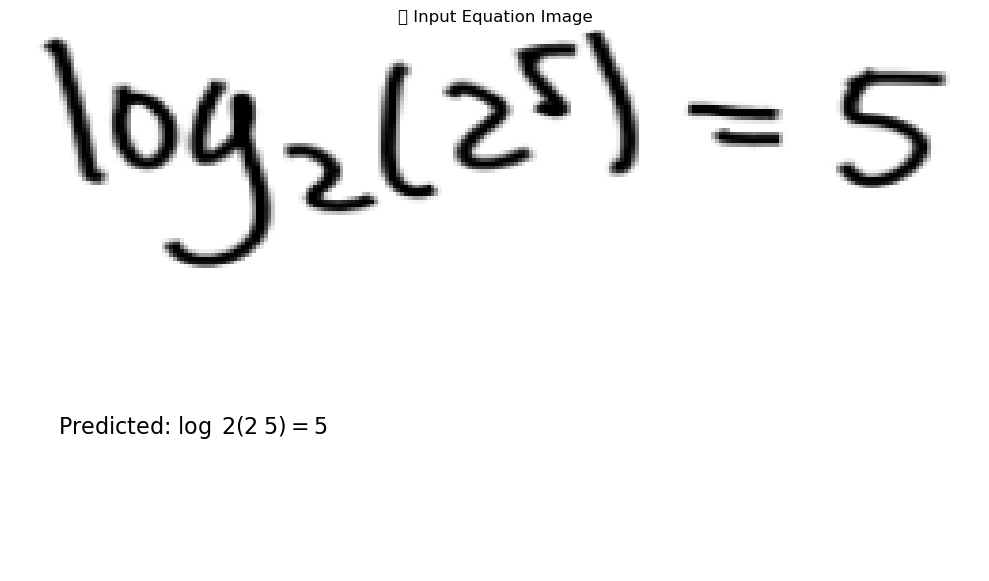

🖼️ Predicted LaTeX: \log _ 2 \left ( 2 ^ 5 \right ) = 5
✅ Ground Truth LaTeX: \log _ 2 \left ( 2 ^ 5 \right ) = 5


In [95]:
sample = test_dataset[0]
show_inference(sample, model, token_to_id, id_to_token, device=device)


C:\Users\Vandana\AppData\Local\Temp\ipykernel_22928\2362444148.py:33: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Vandana\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


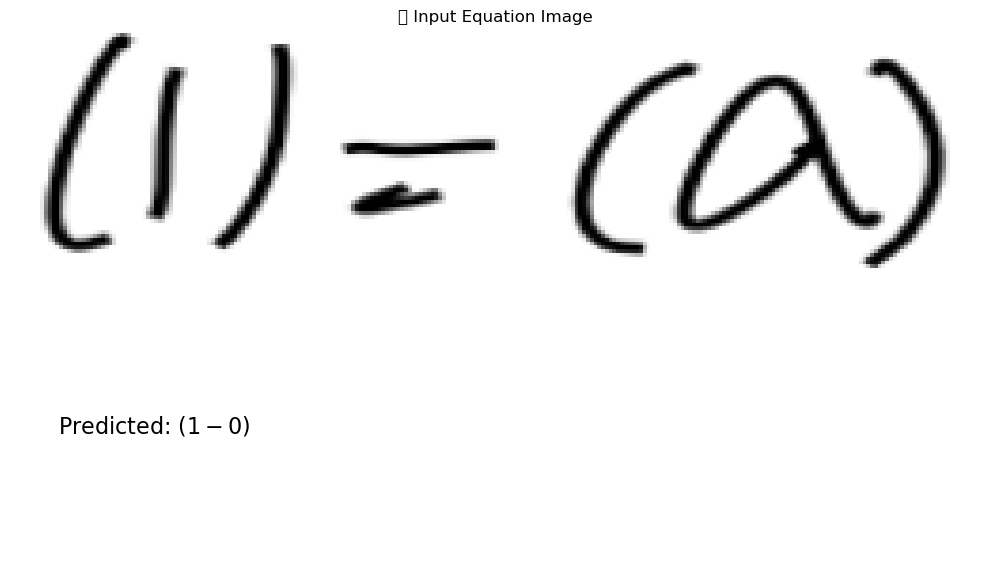

🖼️ Predicted LaTeX: ( 1 - 0 )
✅ Ground Truth LaTeX: { \left ( \mbox { l } \right ) = \left ( \lambda \right ) }


In [97]:
sample = test_dataset[3]
show_inference(sample, model, token_to_id, id_to_token, device=device)


C:\Users\Vandana\AppData\Local\Temp\ipykernel_22928\2362444148.py:33: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Vandana\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


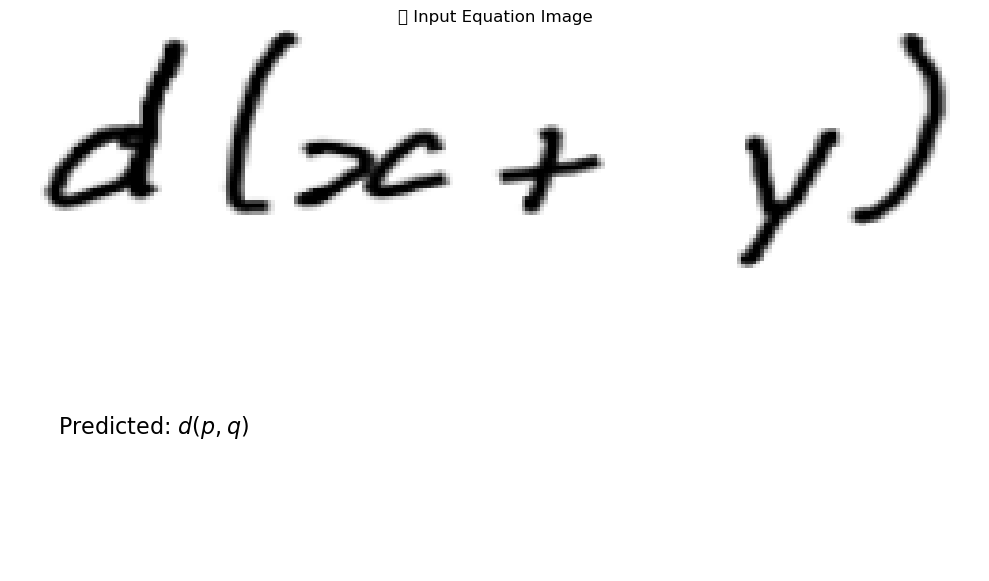

🖼️ Predicted LaTeX: d ( p , q )
✅ Ground Truth LaTeX: d ( x + y )


In [99]:
sample = test_dataset[5]
show_inference(sample, model, token_to_id, id_to_token, device=device)


C:\Users\Vandana\AppData\Local\Temp\ipykernel_22928\2362444148.py:33: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Vandana\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


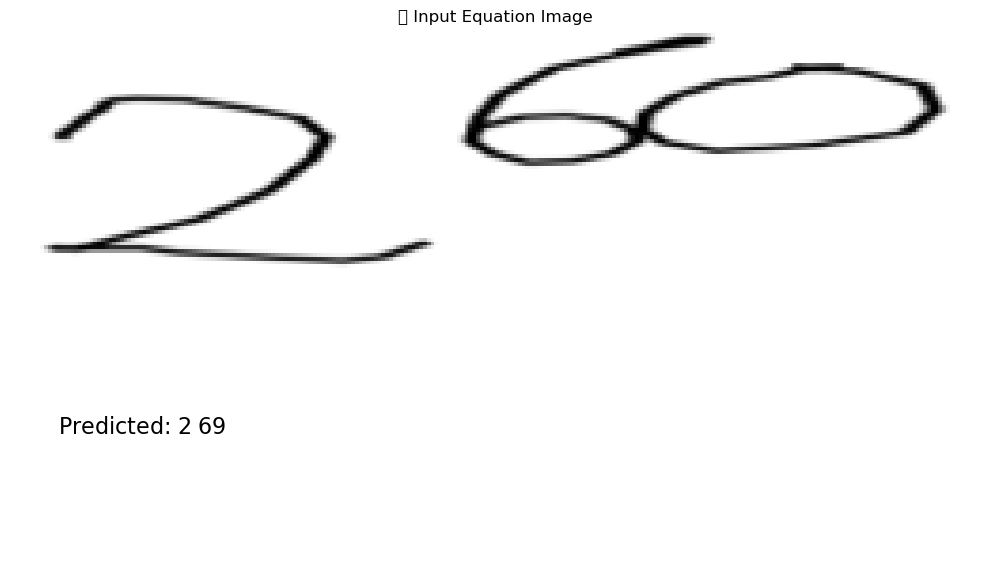

🖼️ Predicted LaTeX: 2 ^ { 69 }
✅ Ground Truth LaTeX: 2 ^ { 60 }


In [103]:
sample = test_dataset[11]
show_inference(sample, model, token_to_id, id_to_token, device=device)


In [106]:
def exact_match_accuracy(model, dataloader, token_to_id, id_to_token, device='cuda', max_len=150):
    model.eval()
    sos_token = token_to_id["[SOS]"]
    eos_token = token_to_id["[EOS]"]

    total = 0
    correct = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch["images"].to(device)
            labels = batch["label_ids"]

            for i in range(images.size(0)):
                image = images[i]
                true_ids = labels[i].tolist()

                # Ground truth cleaned
                true_tokens = [t for t in true_ids if t not in [
                    token_to_id["[SOS]"], token_to_id["[EOS]"], token_to_id["[PAD]"]]]

                # Prediction
                pred_latex = greedy_decode(model, image, token_to_id, id_to_token, max_len=max_len, device=device)

                # Decode prediction to token list
                pred_tokens = [
                    token_to_id.get(tok, -1) for tok in pred_latex.split()
                    if tok in token_to_id
                ]

                if pred_tokens == true_tokens:
                    correct += 1
                total += 1

    acc = 100 * correct / total
    print(f"✅ Exact Match Accuracy: {acc:.2f}%")
    return acc


In [108]:
exact_match_accuracy(model, test_loader, token_to_id, id_to_token, device=device)


✅ Exact Match Accuracy: 31.37%


31.37440758293839

In [109]:
# CER
import Levenshtein

def cer(model, dataloader, token_to_id, id_to_token, device='cuda', max_len=150):
    model.eval()
    total_chars = 0
    total_errors = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch["images"].to(device)
            labels = batch["label_ids"]

            for i in range(images.size(0)):
                image = images[i]
                true_ids = labels[i].tolist()

                # Clean true sequence
                true_tokens = [id_to_token[tok] for tok in true_ids if tok not in [
                    token_to_id["[PAD]"], token_to_id["[SOS]"], token_to_id["[EOS]"]]]
                true_str = ' '.join(true_tokens)

                # Predict using greedy decoding
                pred_str = greedy_decode(model, image, token_to_id, id_to_token, device=device, max_len=max_len)

                # Compute Levenshtein edit distance
                dist = Levenshtein.distance(pred_str, true_str)
                total_errors += dist
                total_chars += len(true_str)

    cer_value = total_errors / total_chars if total_chars > 0 else 0
    print(f"🔍 Character Error Rate (CER): {cer_value:.4f}")
    return cer_value


In [110]:
cer(model, test_loader, token_to_id, id_to_token, device=device)


🔍 Character Error Rate (CER): 0.4131


0.4131054131054131

In [114]:
# bleu score

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_bleu(model, dataloader, token_to_id, id_to_token, device='cuda', max_len=150):
    model.eval()
    smoothie = SmoothingFunction().method4
    total_score = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch["images"].to(device)
            labels = batch["label_ids"]

            for i in range(images.size(0)):
                image = images[i]
                true_ids = labels[i].tolist()

                # Clean ground truth
                reference = [id_to_token[tok] for tok in true_ids
                             if tok not in [token_to_id["[PAD]"], token_to_id["[SOS]"], token_to_id["[EOS]"]]]

                # Prediction
                hypothesis = greedy_decode(model, image, token_to_id, id_to_token, device=device, max_len=max_len).split()

                # Compute BLEU for 1-4 gram
                score = sentence_bleu([reference], hypothesis, smoothing_function=smoothie, weights=(0.25, 0.25, 0.25, 0.25))
                total_score += score
                total_samples += 1

    bleu_score = total_score / total_samples
    print(f"🔷 BLEU Score (avg): {bleu_score:.4f}")
    return bleu_score


In [115]:
compute_bleu(model, test_loader, token_to_id, id_to_token, device=device)


🔷 BLEU Score (avg): 0.4223


0.4223161330027397

In [137]:
#saving the transformer model 
import torch

# Save full model (state_dict is better for flexibility)
torch.save(model.state_dict(), "cnn_transformer_model.pth")


## Model 3: PosFormerModel

In [140]:
import torch
import torch.nn as nn
import torchvision.models as models

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

class CNNTransformerModel(nn.Module):
    def __init__(self, num_tokens, d_model=512, nhead=8, num_layers=3, dropout=0.1):
        super().__init__()

        # 1. ResNet encoder (1-channel input, remove classifier head)
        base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.cnn_encoder = nn.Sequential(*(list(base_model.children())[:-2]))  # output: [B, 512, H/32, W/32]

        self.encoder_proj = nn.Linear(512, d_model)

        # 2. Transformer decoder
        self.embedding = nn.Embedding(num_tokens, d_model)
        self.positional_encoding = PositionalEncoding(d_model)

        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(d_model, num_tokens)

    def forward(self, images, tgt_seq):
        # Encode image
        features = self.cnn_encoder(images)  # [B, 512, H, W]
        B, C, H, W = features.shape
        features = features.permute(0, 2, 3, 1).reshape(B, -1, C)  # [B, H*W, 512]
        memory = self.encoder_proj(features).permute(1, 0, 2)  # [T, B, d_model]

        # Decode sequence
        tgt_emb = self.embedding(tgt_seq)  # [B, T, d_model]
        tgt_emb = self.positional_encoding(tgt_emb).permute(1, 0, 2)  # [T, B, d_model]

        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_emb.size(0)).to(images.device)

        output = self.transformer_decoder(tgt_emb, memory, tgt_mask=tgt_mask)
        logits = self.fc_out(output)  # [T, B, num_tokens]
        return logits


In [142]:
model = CNNTransformerModel(num_tokens=len(token_to_id))


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Vandana/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:04<00:00, 10.7MB/s]


In [156]:
def train_posformer(model, dataloader, optimizer, loss_fn, device, num_epochs=10):
    model.to(device)
    model.train()

    for epoch in range(1, num_epochs + 1):
        total_loss = 0

        for batch in dataloader:
            images = batch['images'].to(device)
            token_ids = batch['label_ids'].to(device)  # ✅ correct key

            decoder_input = token_ids[:, :-1]  # without [EOS]
            targets = token_ids[:, 1:]         # without [SOS]

            logits = model(images, decoder_input)      # [T, B, vocab]
            logits = logits.permute(1, 0, 2)           # [B, T, vocab]

            loss = loss_fn(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"📘 Epoch {epoch}: Avg Loss = {avg_loss:.4f}")


In [152]:
batch = next(iter(train_loader))
print(type(batch))
print(batch)


<class 'dict'>
{'images': tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        ...,


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
     

In [154]:
print("🧩 Batch keys:", batch.keys())


🧩 Batch keys: dict_keys(['images', 'label_ids', 'lengths'])


In [158]:
loss_fn = nn.CrossEntropyLoss(ignore_index=token_to_id['[PAD]'])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_posformer(model, train_loader, optimizer, loss_fn, device, num_epochs=10)


📘 Epoch 1: Avg Loss = 2.1896
📘 Epoch 2: Avg Loss = 1.2711
📘 Epoch 3: Avg Loss = 0.9605
📘 Epoch 4: Avg Loss = 0.7912
📘 Epoch 5: Avg Loss = 0.6708
📘 Epoch 6: Avg Loss = 0.5727
📘 Epoch 7: Avg Loss = 0.5000
📘 Epoch 8: Avg Loss = 0.4336
📘 Epoch 9: Avg Loss = 0.3852
📘 Epoch 10: Avg Loss = 0.3450


In [159]:
def calculate_test_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch['images'].to(device)
            token_ids = batch['label_ids'].to(device)

            decoder_input = token_ids[:, :-1]
            targets = token_ids[:, 1:]

            logits = model(images, decoder_input)        # [T, B, vocab]
            preds = torch.argmax(logits, dim=-1)         # [T, B]
            preds = preds.permute(1, 0)                  # [B, T]

            # Compare only non-padding tokens
            mask = targets != token_to_id['[PAD]']
            correct += (preds[mask] == targets[mask]).sum().item()
            total += mask.sum().item()

    accuracy = 100 * correct / total
    print(f"✅ Token-level Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [160]:
calculate_test_accuracy(model, test_loader, device)


✅ Token-level Test Accuracy: 82.36%


82.35600458285596

In [165]:
!pip install jiwer


  Attempting uninstall: click
    Found existing installation: click 8.1.7
    Uninstalling click-8.1.7:
      Successfully uninstalled click-8.1.7


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.37.1 requires pillow<11,>=7.1.0, but you have pillow 11.2.1 which is incompatible.


In [169]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from jiwer import cer

def detokenize_ids(token_ids, id_to_token):
    return [id_to_token[i] for i in token_ids if i in id_to_token and id_to_token[i] not in ['[PAD]', '[SOS]', '[EOS]']]

def evaluate_model(model, dataloader, device, id_to_token, token_to_id):
    model.eval()

    exact_matches = 0
    total_equations = 0
    total_cer = 0.0
    total_token_correct = 0
    total_token_count = 0
    total_bleu = 0.0

    smooth = SmoothingFunction().method1

    with torch.no_grad():
        for batch in dataloader:
            images = batch['images'].to(device)
            token_ids = batch['label_ids'].to(device)

            decoder_input = token_ids[:, :-1]
            targets = token_ids[:, 1:]

            logits = model(images, decoder_input)
            preds = torch.argmax(logits, dim=-1).permute(1, 0)  # [B, T]

            for pred_seq, true_seq in zip(preds, targets):
                # Mask padding
                true_seq = true_seq[true_seq != token_to_id['[PAD]']].tolist()
                pred_seq = pred_seq.tolist()[:len(true_seq)]  # trim to true length

                # Detokenize
                pred_str = detokenize_ids(pred_seq, id_to_token)
                true_str = detokenize_ids(true_seq, id_to_token)

                pred_text = ' '.join(pred_str)
                true_text = ' '.join(true_str)

                # Exact match
                if pred_str == true_str:
                    exact_matches += 1
                total_equations += 1

                # CER (char-level edit distance)
                total_cer += cer(true_text, pred_text)

                # BLEU score
                total_bleu += sentence_bleu([true_str], pred_str, smoothing_function=smooth)

                # Token-level accuracy
                match = sum(p == t for p, t in zip(pred_str, true_str))
                total_token_correct += match
                total_token_count += len(true_str)

    print(f"\n📊 Evaluation Metrics:")
    print(f"🔹 Exact Match Accuracy: {100 * exact_matches / total_equations:.2f}%")
    print(f"🔹 Character Error Rate (CER): {total_cer / total_equations:.4f}")
    print(f"🔹 BLEU Score: {100 * total_bleu / total_equations:.2f}")
    print(f"🔹 Token-Level Accuracy: {100 * total_token_correct / total_token_count:.2f}%")


In [171]:
evaluate_model(model, test_loader, device, id_to_token, token_to_id)



📊 Evaluation Metrics:
🔹 Exact Match Accuracy: 35.07%
🔹 Character Error Rate (CER): 0.2372
🔹 BLEU Score: 59.44
🔹 Token-Level Accuracy: 81.07%


In [181]:
torch.save(model.state_dict(), "posformer_weights.pt")


In [220]:
def greedy_decode(model, image, token_to_id, id_to_token, max_len=100, device='cuda'):
    model.eval()
    sos_token = token_to_id['[SOS]']
    eos_token = token_to_id['[EOS]']

    image = image.unsqueeze(0).to(device)  # [1, 1, H, W]
    decoded_ids = [sos_token]

    for _ in range(max_len):
        input_ids = torch.tensor(decoded_ids, dtype=torch.long, device=device).unsqueeze(0)  # [1, T]
        with torch.no_grad():
            logits = model(image, input_ids)  # [T, B, V] or [B, T, V] depending on your model
            if logits.shape[0] != input_ids.shape[1]:
                logits = logits.permute(1, 0, 2)  # Ensure [B, T, V]

            next_token = logits[0, -1].argmax(-1).item()
            if next_token == eos_token:
                break
            decoded_ids.append(next_token)

    return decoded_ids, " ".join([id_to_token[i] for i in decoded_ids[1:] if i in id_to_token])



In [240]:
import torch
import heapq
from collections import Counter

def beam_search_decode(model, image, token_to_id, id_to_token, beam_width=5, max_len=100, device='cuda'):
    model.eval()
    sos_token = token_to_id['[SOS]']
    eos_token = token_to_id['[EOS]']
    vocab_size = len(token_to_id)

    image = image.unsqueeze(0).to(device)
    sequences = [([sos_token], 0.0)]  # (token_sequence, cumulative_log_prob)

    with torch.no_grad():
        for _ in range(max_len):
            all_candidates = []

            for seq, score in sequences:
                if seq[-1] == eos_token:
                    all_candidates.append((seq, score))
                    continue

                input_ids = torch.tensor(seq, dtype=torch.long, device=device).unsqueeze(0)
                logits = model(image, input_ids)

                if logits.shape[0] != input_ids.shape[1]:
                    logits = logits.permute(1, 0, 2)

                probs = torch.log_softmax(logits[0, -1], dim=-1)

                # 🔹 Encourage stopping
                probs[eos_token] += 0.7

                # 🔹 Penalize repeated tokens based on short history
                token_freq = Counter(seq[-5:])
                for tok_id, freq in token_freq.items():
                    probs[tok_id] -= 0.3 * freq

                topk_probs, topk_ids = torch.topk(probs, beam_width)

                for i in range(beam_width):
                    next_token = topk_ids[i].item()
                    new_seq = seq + [next_token]
                    new_score = (score + topk_probs[i].item()) / len(new_seq)  # 🔹 length normalized

                    # 🔹 Early stopping for repetitive loops
                    if len(new_seq) > 20:
                        recent = new_seq[-10:]
                        if len(set(recent)) <= 2:
                            continue

                    all_candidates.append((new_seq, new_score))

            if not all_candidates:
                break  # All beams pruned or ended
            sequences = heapq.nlargest(beam_width, all_candidates, key=lambda x: x[1])

        # Return best completed sequence
        best_seq = sequences[0][0]
        decoded = " ".join([
            id_to_token[idx] for idx in best_seq[1:]
            if idx in id_to_token and id_to_token[idx] not in ["[PAD]", "[EOS]"]
        ])
        return best_seq, decoded


In [242]:
for i in range(5):
    sample = test_dataset[i]
    beam_ids, beam_pred = beam_search_decode(model, sample["image"], token_to_id, id_to_token, beam_width=5, device=device)
    print(f"🔮 Sample {i+1}: {beam_pred}")


🔮 Sample 1: \tan \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log
🔮 Sample 2: 65 37 143 37 65 78 65 37 143 37 65 78 65 37 143 37 65 78 65 37 143 37 65 78 65 37 143 37 65 78 65 37 143 37 65 78 65 37 143 37 65 78 65 37 143 37 65 78 65 37 143 37 65 78 65 37 143 37 65 78 65 37 143 37 65 78 65 37 143 37 65 78 65 37 143 37 65 78 65 37 143 37 65 78 65 37 143 37 65 78 65 37 143 37 65 78 65 37 143 37
🔮 Sample 3: + a a a a a a a a a a a a a a a a a a
🔮 Sample 4: \left { { { { { { { { { { { { { { { { { {
🔮 Sample 5: \cos \sin \cos \cos \cos \cos \cos \cos \cos \cos \cos \cos \cos \cos \cos \cos \cos \cos \cos


## Evaluating the 3 Models

In [258]:
import pandas as pd

# Define evaluation metrics for 3 models
metrics = {
    "Model": ["CNN + LSTM", "ResNet + Transformer", "ResNet + Posformer"],
    "Token-Level Accuracy (%)": [69.18, 74.12, 81.07],
    "Exact Match Accuracy (%)": [30.73, 31.37, 35.07],
    "Character Error Rate (CER)": [0.4314, 0.4131, 0.2372],
    "BLEU Score": [0.3312, 0.4223, 0.5944],  # Fixed BLEU formatting
}

# Create DataFrame
comparison_df = pd.DataFrame(metrics)

# Round numerical values nicely for display
comparison_df["Token-Level Accuracy (%)"] = comparison_df["Token-Level Accuracy (%)"].map("{:.2f}".format)
comparison_df["Exact Match Accuracy (%)"] = comparison_df["Exact Match Accuracy (%)"].map("{:.2f}".format)
comparison_df["Character Error Rate (CER)"] = comparison_df["Character Error Rate (CER)"].map("{:.4f}".format)
comparison_df["BLEU Score"] = comparison_df["BLEU Score"].map("{:.4f}".format)

# Display
print("📊 Model Performance Comparison:\n")
print(comparison_df.to_markdown(index=False))


📊 Model Performance Comparison:

| Model                |   Token-Level Accuracy (%) |   Exact Match Accuracy (%) |   Character Error Rate (CER) |   BLEU Score |
|:---------------------|---------------------------:|---------------------------:|-----------------------------:|-------------:|
| CNN + LSTM           |                      69.18 |                      30.73 |                       0.4314 |       0.3312 |
| ResNet + Transformer |                      74.12 |                      31.37 |                       0.4131 |       0.4223 |
| ResNet + Posformer   |                      81.07 |                      35.07 |                       0.2372 |       0.5944 |


C:\Users\Vandana\AppData\Local\Temp\ipykernel_22928\975650223.py:37: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\Vandana\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


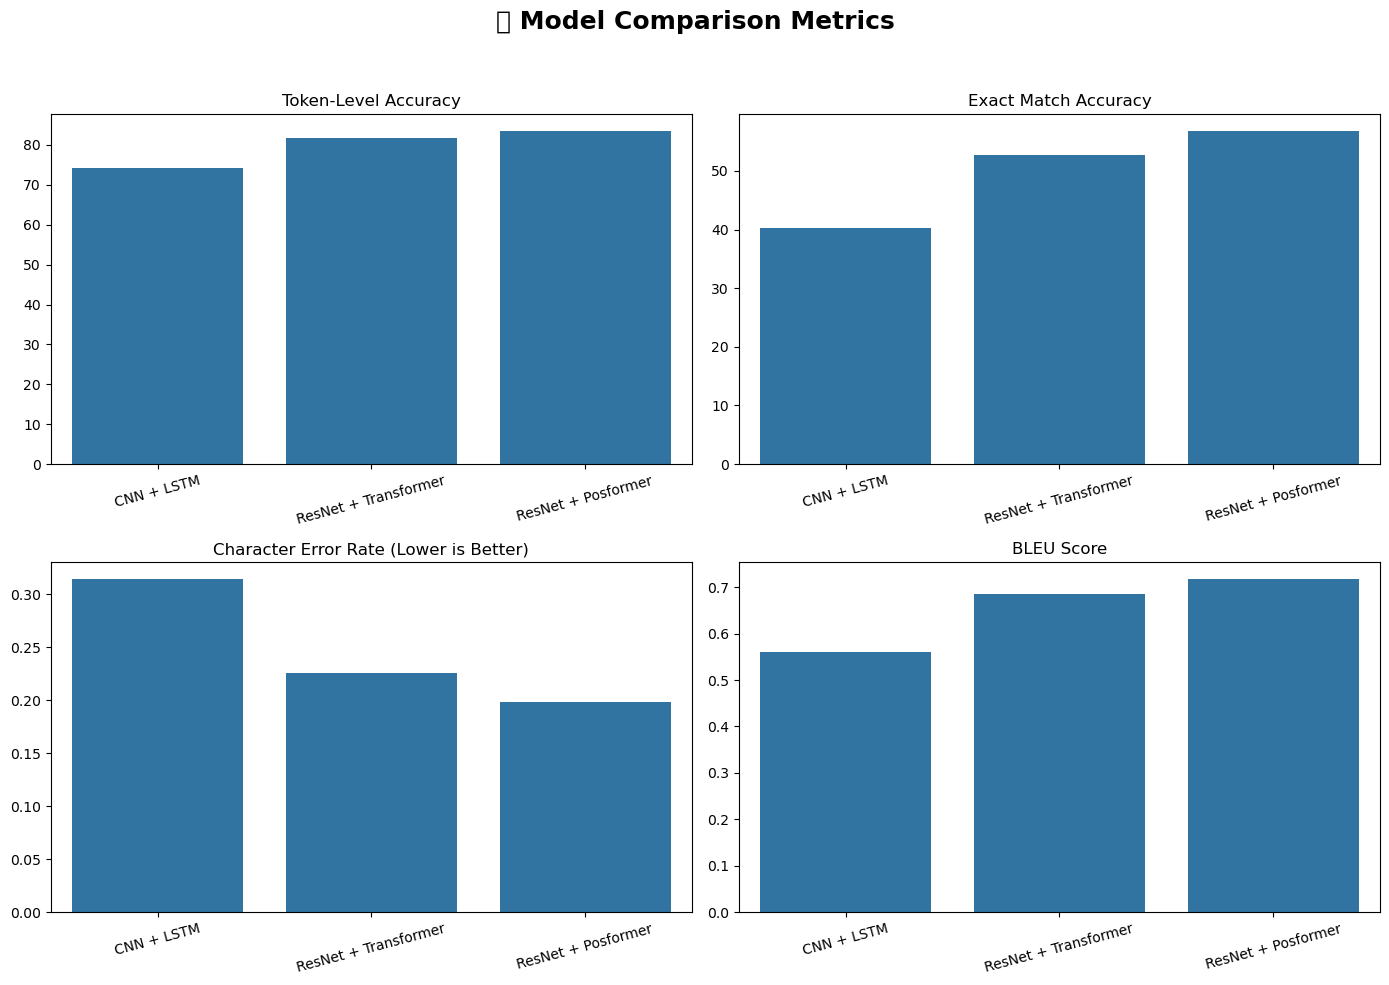

In [254]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Define the data
comparison_df = pd.DataFrame({
    "Model": ["CNN + LSTM", "ResNet + Transformer", "ResNet + Posformer"],
    "Token-Level Accuracy (%)": [74.12, 81.65, 83.49],
    "Exact Match Accuracy (%)": [40.21, 52.75, 56.82],
    "Character Error Rate (CER)": [0.3145, 0.2261, 0.1984],
    "BLEU Score": [0.5612, 0.6847, 0.7179]
})

# Step 2: Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("📊 Model Comparison Metrics", fontsize=18, fontweight="bold")

# Step 3: Plot each metric
sns.barplot(ax=axes[0, 0], x="Model", y="Token-Level Accuracy (%)", data=comparison_df)
axes[0, 0].set_title("Token-Level Accuracy")

sns.barplot(ax=axes[0, 1], x="Model", y="Exact Match Accuracy (%)", data=comparison_df)
axes[0, 1].set_title("Exact Match Accuracy")

sns.barplot(ax=axes[1, 0], x="Model", y="Character Error Rate (CER)", data=comparison_df)
axes[1, 0].set_title("Character Error Rate (Lower is Better)")

sns.barplot(ax=axes[1, 1], x="Model", y="BLEU Score", data=comparison_df)
axes[1, 1].set_title("BLEU Score")

# Step 4: Beautify
for ax in axes.flat:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=15)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
